In [42]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import threading


#### Group Assignment
- Team Number: <font color="yellow"> 12 </font>
- Team Member Names: <font color="yellow"> Robin Zhang, Jessica Chen, Eric Wang </font>
- Team Strategy Chosen: <font color="red"> Risky </font>

In [115]:
start_date = "2019-01-01"
end_date = "2022-11-25"
targetNumberofStocks = 12
maxWeight = 0.25
initialInvestment = 500000

In [106]:
#Call the CSV file and store it in a dataframe
tickers = pd.read_csv('Tickers_Example.csv')
length = len(tickers)

#Clean the the dataframe
colname = tickers.columns[0]

#rename tickers columns and create missing_data dataframe
tickers.columns = ['Tickers']
missing_data = pd.DataFrame({'Tickers': [colname]})

#append the two dataframes
tickers = pd.concat([missing_data, tickers])

tickers.reset_index(inplace=True, drop=True)
#make list of tickers
ticker_list = list(tickers.Tickers)

#set the start and end dates for the filter
start_date_filter = '2022-01-01'
end_date_filter = '2022-10-01'
#empty series to hold volume of tickers
ticker_data = {}
#empty list to temporarily hold the sorted tickers
new_lst = []
#set counter (i) to 0
i=0

for t in ticker_list:

    #get the historical data for the ticker
    firm = yf.Ticker(ticker_list[i])
    firm_hist = firm.history(start=start_date_filter, end=end_date_filter, interval='1mo')
    firm_hist.reset_index(inplace=True)

    #filter and remove rows that do not have at least 20 business days
    for x in range(len(firm_hist)-1):
        #x should 
        first_month = firm_hist.iloc[x, 0].strftime('%Y-%m-%d')
        next_month = firm_hist.iloc[x+1, 0].strftime('%Y-%m-%d')
        if np.busday_count(first_month, next_month) < 20:
            #drop the row of hist
            firm_hist.drop([x, 0])


    ticker_data[t] = firm_hist.Volume

    if ticker_data[t].mean() > 200000:
        #make a new lst that stores the values where mean >200 000
        #return that list
        new_lst.append(ticker_list[i])

    i = i + 1

ticker_list = new_lst
#remove all tickers not listed on US market
#by deleting all values with a "." in them
for t in ticker_list:
    if "." in t:
        ticker_list.remove(t)

print(ticker_list)

- AGN: No data found, symbol may be delisted
- CELG: No data found, symbol may be delisted
- PCLN: No data found for this date range, symbol may be delisted
- RTN: No data found, symbol may be delisted
- TWX: No data found for this date range, symbol may be delisted
['AAPL', 'ABBV', 'ABT', 'ACN', 'AIG', 'AMZN', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BLK', 'BMY', 'C', 'CAT', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CSCO', 'CVS', 'GM', 'GOOG', 'JPM', 'KMI', 'KO', 'LLY', 'LMT', 'MO', 'MON', 'MRK', 'MS', 'MSFT', 'NEE', 'NKE', 'ORCL', 'OXY', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'SBUX', 'SLB', 'SO', 'SPG', 'T', 'TGT', 'TXN', 'UNH', 'UNP', 'UPS', 'USB']


In [52]:
class Stock:

    # Initializing values when class is created
    def __init__(self, ticker, start, end, market='^GSPC'):
        
        # Initializing the Parameters of the Function
        self.ticker = ticker
        self.start = start
        self.end = end
        
        # Market
        self.marketTicker = market
        
        self.makeDataDict()
        self.makeDataFrame()
        self.makeColumns()
        self.getSTD()
        self.getBeta()
        
    def __str__(self):
        return self.ticker + ": " + str(self.std)
    
    # This function allow us to sort instances of the class based on their std
    def __gt__(self, other):
        return self.std < other.std

    # Takes the history of the ticker and market and puts in dictionary
    def makeDataDict(self):
        self.companies = {}
        self.companies[self.ticker] = yf.Ticker(self.ticker).history(start = self.start, end = self.end)['Close']
        self.companies[self.marketTicker] = yf.Ticker(self.marketTicker).history(start = self.start, end = self.end)['Close']


    # Creates a DataFrame for the Data, Get its intervals by the weekly
    def makeDataFrame(self):
        self.companiesDF = pd.DataFrame(self.companies)
        self.companiesDF = self.companiesDF.groupby(pd.Grouper(axis=0, freq='1W')).first()
        self.companiesDF['pct']=self.companiesDF[self.ticker].pct_change() 
        
    def makeColumns(self):
        self.columns = []
        for column in self.companiesDF.iteritems():
            self.columns.append(column[0])
            
    def graphChange(self):
        self.dateRange = pd.date_range(start=self.start, end=self.end, freq=pd.offsets.Week(1))
        plt.plot(self.dateRange, self.companiesDF['pct'], label = x)
        plt.title("Portfolio Stock Changes", fontsize=20)
        self.makeGraph(True)
        
    def getSTD(self):
        self.std = self.companiesDF['pct'].std()
        
    # Graphs the price of the Stocks
    def graphStocks(self):
        self.dateRange = pd.date_range(start=self.start, end=self.end, freq=pd.offsets.Week(1))
        for x in self.columns:
            plt.plot(self.dateRange, self.companiesDF[x], label = x)
        plt.title("Portfolio Stock Prices", fontsize=20)
        self.makeGraph(True)
    

    # Adds the Axis and Customization to Graphs
    def makeGraph(self, legend=False):
        plt.xticks(rotation=70)
        plt.xlabel("Dates", fontsize=14)
        plt.ylabel("Price $(USD)", fontsize=14)
        if legend:
            plt.legend(bbox_to_anchor=(1.0, 1.0))
            
    '''
    purpose:
        calculates beta between each individual stock and the overall market (SP500 index)
    output: 
        Beta Value
    '''
    def getBeta(self):
        self.marketVar=self.companiesDF[self.marketTicker].pct_change().var()
        self.pctChangeDF=pd.DataFrame()
        
        self.pctChangeDF['pct']=self.companiesDF[self.ticker].pct_change()
        self.pctChangeDF[self.marketTicker]=self.companiesDF[self.marketTicker].pct_change()
        self.pctChangeDF.dropna(inplace=True)
        
        self.beta=self.pctChangeDF.cov()/self.marketVar
        self.beta=np.absolute(self.pctChangeDF.iloc[0,0])
        return self.beta
    

In [53]:
stockObjects = []
Threads=[]

def makeObjects(ticker):
    stockObjects.append(Stock(ticker, start_date, end_date))

for x in ticker_list:
    t = threading.Thread(target=makeObjects, args=[x])
    t.start()
    Threads.append(t)

for thread in Threads:
    thread.join()

stockObjects.sort()
for x in stockObjects:
    print(x)
mainStock = stockObjects[0]
print("The stock with the highest standard deviation will be: " + mainStock.ticker)

OXY: 0.10442472835150167
BA: 0.08406397196832115
SPG: 0.07263608026126495
SLB: 0.07054411137267215
BIIB: 0.06838303267259613
COP: 0.0628119180107266
AIG: 0.0626347809129161
PYPL: 0.060538308148063824
QCOM: 0.05964564997996106
GM: 0.059277303214765015
COF: 0.059242485575311706
AXP: 0.0549688140200644
C: 0.05464085457266613
BAC: 0.05064397879967495
NKE: 0.05050130979982979
AMZN: 0.04913931749328961
BLK: 0.049135915459825846
MS: 0.0488487712060125
TGT: 0.04727516556847981
CAT: 0.046870941500218144
USB: 0.0466028869341513
BK: 0.04509005099131792
JPM: 0.044927264287675475
KMI: 0.04483432876810731
NEE: 0.044025623927542466
AAPL: 0.044025251119137104
UPS: 0.04243561233382388
UNH: 0.04160491356836688
SBUX: 0.04084594771504
CVS: 0.04063982486532259
UNP: 0.04012670828512127
SO: 0.0391997717166787
MSFT: 0.03901868302126645
LMT: 0.03891884618006873
ABT: 0.03863746052086046
PM: 0.038471126428659505
LLY: 0.038327751073350194
MO: 0.03820761085823249
TXN: 0.038150250532268046
PFE: 0.03807768674065558


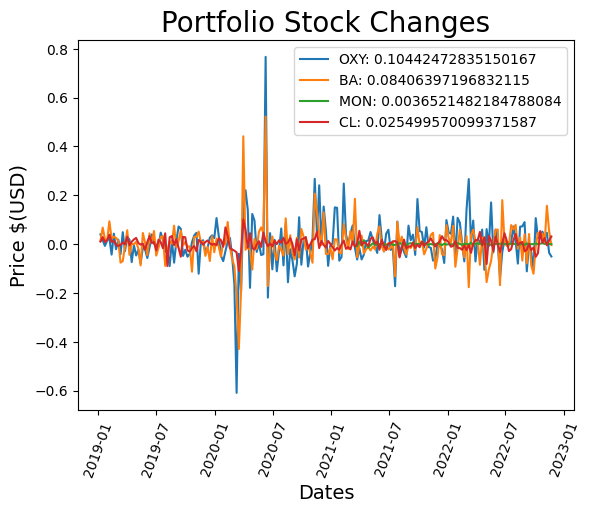

In [54]:
counter = 0
for x in stockObjects:
    if counter < 2:
        x.graphChange()
        counter = counter+1
        
stockObjects.reverse()

counter = 0
for x in stockObjects:
    if counter < 2:
        x.graphChange()
        counter = counter+1

In [68]:
# currently not working with class objects
def findHighestBeta(tickerList):
    '''
    purpose:
        calculates beta between each individual stock and the overall market (SP500 index)
    input:
        tickerList (listof Stock): a list of Stock objects
    output: 
        A list of the beta of each stock in tickerList (assume US market)
    '''

    highestBetaObj= tickerList[0]
    highestBeta = 0
    for ticker in tickerList:
        if(np.absolute(ticker.beta)>highestBeta):
            highestBeta = ticker.beta
            highestBetaObj = ticker

    return highestBetaObj

highBetaStock = findHighestBeta(stockObjects)
print(highBetaStock.ticker + ":", highBetaStock.beta)


SLB: 0.07983835732349065


Althought SLB have the highest Beta, it only has he 4th highest standard deviation. This demonstrated the fact that just evaluating the market risk of a stock is not enough to determine the it's volatility

In [70]:
def calculateCorrelation(ticker1, ticker2):
    '''
    purpose:
        calculates the correlation between two stock
    input:
        ticker1 (Stock): Stock object 1
        ticker2 (Stock): Stock object 2
    output: 
        A value between -1 to 1 that represents the correlation
        between the given tickers
    '''
    correlation=pd.DataFrame()
    correlation[ticker1.ticker]=ticker1.companiesDF['pct']
    correlation[ticker2.ticker]=ticker2.companiesDF['pct']
    correlation=correlation.corr()
    correlation=correlation.iloc[0,1]


    return correlation

In [113]:
def selectPortfolio(mainStock, tickerList):
    portfolio = {mainStock:1}
    correlationDict = dict()
    
    for ticker in tickerList:
        if ticker.ticker != mainStock.ticker:
            correlationDict[ticker] = calculateCorrelation(mainStock, ticker)

    threshold = 0.95 
    while True:
        for key in correlationDict:
            if correlationDict[key] >= threshold:
                portfolio[key] = correlationDict[key]       
        if len(portfolio) < targetNumberofStocks:
                portfolio = {mainStock:1}
                threshold -= 0.05
        elif len(portfolio) > targetNumberofStocks:
                portfolio = {mainStock:1}
                threshold += 0.00001
        else:
            break
        
    return portfolio

portfolioObj = list(sorted(selectPortfolio(mainStock, stockObjects).items(), key=lambda x:x[1], reverse=True))
highestCorrelationObj = portfolioObj[1][0]
secondHighestCorrelationObj = portfolioObj[2][0]

for pair in portfolioObj:
    print(pair[0].ticker + " and OXY:", pair[1])
portfolioObj = dict(portfolioObj)

OXY and OXY: 1
SLB and OXY: 0.7754844837818032
COP and OXY: 0.7447473899385436
KMI and OXY: 0.6653803549225865
SPG and OXY: 0.6410347814302297
USB and OXY: 0.58776084063311
C and OXY: 0.578053105538381
BAC and OXY: 0.5524917078394994
JPM and OXY: 0.545425561115637
AIG and OXY: 0.5298421420151554
BA and OXY: 0.5298376921302023
CAT and OXY: 0.5270609510239472


In [130]:
def portfolioFinal(portfolioObj):
    totalWeight = 1
    tempDict = dict()
    tempPrice = []
    tempShares = []
    tempValue = []
    tempWeight = []
    tempTicker = []

    for ticker in portfolioObj:
        # @TODO change it to 11-25 to 11-26
        price = list(yf.Ticker(ticker.ticker).history(start = "2022-11-23", end = "2022-11-24", interval='1d')['Close'])[0]
        tempPrice.append(price)
        weight = 0

        if(ticker.ticker != mainStock.ticker and ticker.ticker != highestCorrelationObj.ticker and ticker.ticker != secondHighestCorrelationObj.ticker):
            weight = (100/(2*targetNumberofStocks))/100
            totalWeight -= weight
        elif(ticker.ticker == mainStock.ticker or ticker.ticker == highestCorrelationObj.ticker):
            weight = maxWeight
            totalWeight -= weight
        elif(ticker.ticker == secondHighestCorrelationObj.ticker):
            weight = 1 - (((targetNumberofStocks-3) * (100/(2*targetNumberofStocks))/100) + 2 * maxWeight)

        tempWeight.append(weight)
        value = initialInvestment*weight
        tempValue.append(value)
        tempShares.append(value/price)
        tempTicker.append(ticker.ticker)

    tempDict = {"Ticker":tempTicker, "Price":tempPrice, "Shares":tempShares, 
    "Value":tempValue, "Weight":tempWeight, }
    Portfolio_Final = pd.DataFrame(tempDict)

    Portfolio_Final.index += 1

    return Portfolio_Final

Portfolio_Final = portfolioFinal(portfolioObj)
print("Sanity Check: ")
print("Total Value: $" + str(Portfolio_Final.Value.sum()))
print("Total Weight: " + str(Portfolio_Final.Weight.sum()*100) + "%")
print("Total Value of (Price * Shares): $" + str((Portfolio_Final.Price * Portfolio_Final.Shares).sum()))
Portfolio_Final


Sanity Check: 
Total Value: $500000.0
Total Weight: 100.0%
Total Value of (Price * Shares): $500000.0


,Ticker,Price,Shares,Value,Weight
1,OXY,71.120003,1757.592733,125000.000000,0.250000
2,SLB,51.419998,2430.960802,125000.000000,0.250000
3,COP,126.739998,493.135561,62500.000000,0.125000
4,KMI,18.650000,1117.068834,20833.333333,0.041667
5,SPG,119.610001,174.177186,20833.333333,0.041667
6,USB,44.110001,472.304082,20833.333333,0.041667
7,C,48.240002,431.868421,20833.333333,0.041667
8,BAC,37.610001,553.930683,20833.333333,0.041667
9,JPM,136.479996,152.647523,20833.333333,0.041667
10,AIG,60.959999,341.754161,20833.333333,0.041667


In [131]:
def outputCSV(Portfolio_Final):
    Stocks_Group_12 = pd.DataFrame(Portfolio_Final[['Ticker', 'Shares']])
    Stocks_Group_12.to_csv("Stocks_Group_12.csv")
    return Stocks_Group_12

Stocks_Group_12 = outputCSV(Portfolio_Final)
Stocks_Group_12


,Ticker,Shares
1,OXY,1757.592733
2,SLB,2430.960802
3,COP,493.135561
4,KMI,1117.068834
5,SPG,174.177186
6,USB,472.304082
7,C,431.868421
8,BAC,553.930683
9,JPM,152.647523
10,AIG,341.754161


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

- Robin:
- Jessica:
- Eric: 